# Daytime population density in the Bay Area

Tract-level daytime population is approximated as tract total population, minus outbound commuters, plus inbound commuters. This does, of course, ignore or undercount the flow of tourists, shoppers, students, the self-employed, and populations less-legible to these data products, such as certain minority groups and the homeless.

Input data files:
  - Census tracts 2010 TIGER/Line shapefile with DP1 data ([source](http://www2.census.gov/geo/tiger/TIGER2010DP1/Tract_2010Census_DP1.zip))
  - California LEHD LODES7 2010 origin-destination main data ([source](https://lehd.ces.census.gov/data/lodes/LODES7/ca/od/ca_od_main_JT00_2010.csv.gz))
  - Census bureau 2010 US states 1:500,000 resolution shapefile ([source](http://www2.census.gov/geo/tiger/GENZ2010/gz_2010_us_040_00_500k.zip))

In [1]:
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt, matplotlib.cm as cm
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
%matplotlib inline

In [2]:
# CA's lodes: lehd origin-destination employment statistics (block-level)
# main file includes jobs with both workplace and residence in the state
# jt00 is all job types
lodes_filepath = 'data/ca_od_main_JT00_2010.csv' #lodes data file
tracts_filepath = 'data/Tract_2010Census_DP1' #census tracts shapefile with pop data
states_filepath = 'data/gz_2010_us_040_00_500k' #states shapefile

In [3]:
def load_str(value):
    return str(value)
converters = {'w_geocode' : load_str,
              'h_geocode' : load_str}

# load the lodes data and preserve fips codes as strings bc of preceding zeros
lodes = pd.read_csv(lodes_filepath, converters=converters)

In [4]:
# h_geocode is home residence block fips
# w_geocode is workplace block fips
# S000 is total number of jobs commuting from h_geocode to w_geocode
lodes.head()

,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,060014001001000,060014001001015,1,0,1,0,0,0,1,0,0,1,20160229
1,060014001001000,060014001001036,1,0,1,0,0,0,1,0,0,1,20160229
2,060014001001000,060014001001044,1,0,0,1,0,0,1,0,0,1,20160229
3,060014001001000,060014001001047,1,1,0,0,1,0,0,0,1,0,20160229
4,060014001001000,060014002001004,1,0,0,1,1,0,0,0,0,1,20160229


In [5]:
# extract home and work tract fips codes from the block fips codes
lodes['h_tract'] = lodes['h_geocode'].map(lambda x: x[0:11])
lodes['w_tract'] = lodes['w_geocode'].map(lambda x: x[0:11])

In [6]:
# how many workers commute from each tract
leave_from = lodes.groupby('h_tract')['S000'].sum()

In [7]:
# how many workers commute to each tract
travel_to = lodes.groupby('w_tract')['S000'].sum()

In [8]:
# verify that the counts match up
leave_from.sum() == travel_to.sum()

True

In [9]:
# create df indexed by tract with columns for number of workers leaving from and commuting to
commutes = pd.DataFrame(data={'travel_to':travel_to, 'leave_from':leave_from})
len(commutes)

8033

In [10]:
commutes.head()

,leave_from,travel_to
06001400100,1205.0,13982.0
06001400200,1012.0,1302.0
06001400300,2547.0,1758.0
06001400400,1814.0,697.0
06001400500,1604.0,397.0


## Merge with tracts shapefile of population

In [11]:
# load tracts shapefile that contains pop data
tracts_all = gpd.read_file(tracts_filepath)
len(tracts_all)

74002

In [12]:
# filter to retain only tracts in bay area counties
state = '06'
counties = ['001', '013', '041', '055', '075', '081', '085', '087', '095', '097']
state_counties = ['{}{}'.format(state, county) for county in counties]
tracts_all['state_county'] = tracts_all['GEOID10'].map(lambda x: x[0:5])

In [13]:
tracts_bayarea = tracts_all[tracts_all['state_county'].isin(state_counties)]
len(tracts_bayarea)

1641

In [14]:
# retain only subset of columns then index by tract fips code
tracts = tracts_bayarea[['geometry', 'GEOID10', 'ALAND10', 'DP0010001']]
tracts = tracts.set_index('GEOID10')
tracts.head()

,geometry,ALAND10,DP0010001
GEOID10,,,
06085509201,POLYGON ((-122.0695499999999 37.40840000000003...,1579162.0,4603
06085510500,"POLYGON ((-122.11405 37.38211000000013, -122.1...",2590775.0,4688
06085509401,POLYGON ((-122.1200529999999 37.40625800000009...,666430.0,3212
06085509303,POLYGON ((-122.0970799999999 37.40364000000005...,573577.0,3706
06085503306,POLYGON ((-121.8168219999999 37.32850500000006...,1667716.0,4311


In [15]:
# merge tract shapefile with commutes data on tract fips code
gdf = pd.merge(tracts, commutes, how='left', left_index=True, right_index=True)
len(gdf)

1641

In [16]:
# fill in nulls as zeros then convert all non-geometry columns to int
gdf = gdf.fillna(value=0)
for col in gdf.columns:
    if not col == 'geometry':
        gdf[col] = gdf[col].astype(int)

In [17]:
# calculate daytime pop and density (as persons per sq km)
gdf['daytime_pop'] = gdf['DP0010001'] + gdf['travel_to'] - gdf['leave_from']
gdf['daytime_density'] = gdf['daytime_pop'] / (gdf['ALAND10'] / 1e6)
gdf = gdf.fillna(value=0)
gdf.head()

,geometry,ALAND10,DP0010001,leave_from,travel_to,daytime_pop,daytime_density
GEOID10,,,,,,,
06085509201,POLYGON ((-122.0695499999999 37.40840000000003...,1579162,4603,2196,2027,4434,2807.818324
06085510500,"POLYGON ((-122.11405 37.38211000000013, -122.1...",2590775,4688,1739,670,3619,1396.879312
06085509401,POLYGON ((-122.1200529999999 37.40625800000009...,666430,3212,1471,1414,3155,4734.180634
06085509303,POLYGON ((-122.0970799999999 37.40364000000005...,573577,3706,1390,298,2614,4557.365445
06085503306,POLYGON ((-121.8168219999999 37.32850500000006...,1667716,4311,1514,610,3407,2042.913781


## Visualize it

In [18]:
# define vars
attribute = 'daytime_density'
epsg_utm = 26910 #utm zone 10n
epsg_latlng = 4326 #lat-long

In [19]:
# project tracts to utm
gdf = gdf.to_crs(epsg=epsg_utm)

In [20]:
# load california polygon and trim tracts to its shape to clean up water artifacts
# pretty coarse-grained, but it works ok to make the bay more legible
usa = gpd.read_file(states_filepath).to_crs(epsg=epsg_utm)
calif = usa[usa['NAME']=='California']['geometry'].iloc[0]
gdf['geometry'] = gdf.intersection(calif)

In [21]:
# helper function to assign colors to quantile bins
def get_bin_colors(n, cmap='viridis', start=0., stop=1., alpha=1.):
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors

In [22]:
# quantile cut the tracts according to some attribute
num_bins = 7
bin_labels = range(num_bins)
gdf['bin'] = pd.qcut(x=gdf[attribute], q=num_bins, labels=bin_labels)
bin_colors = get_bin_colors(num_bins, cmap='plasma')

In [23]:
bin_colors

[(0.050382999999999997, 0.029803, 0.52797499999999997, 1.0),
 (0.36255300000000001, 0.0032429999999999998, 0.64924499999999996, 1.0),
 (0.61066699999999996, 0.090204000000000006, 0.61995100000000003, 1.0),
 (0.79821600000000004, 0.28019699999999997, 0.46953800000000001, 1.0),
 (0.92832899999999996, 0.47297499999999998, 0.326067, 1.0),
 (0.99381399999999998, 0.70474099999999995, 0.18304300000000001, 1.0),
 (0.94001500000000004, 0.97515799999999997, 0.131326, 1.0)]

In [24]:
# assign a choropleth facecolor to each tract according to quantile bin
gdf['facecolor'] = gdf['bin'].astype(int).map(lambda x: bin_colors[x])

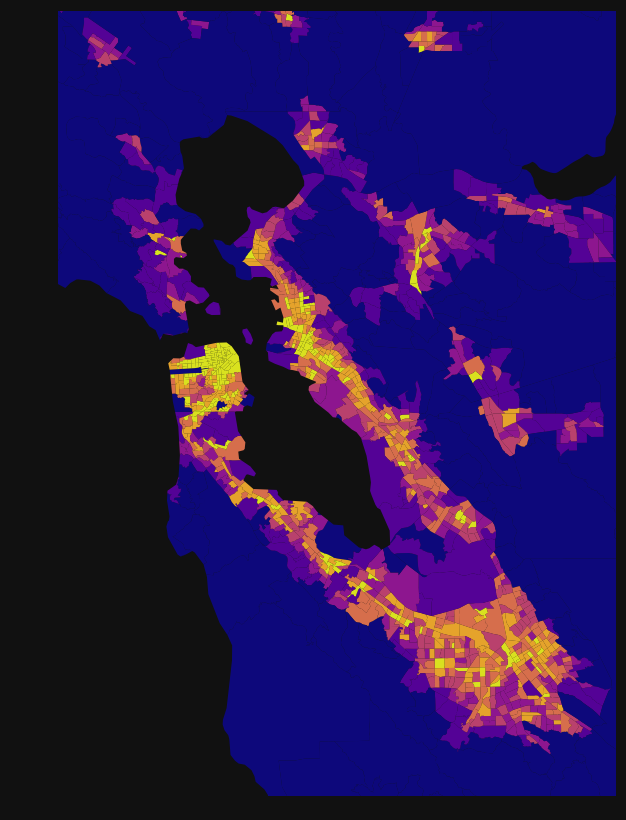

In [25]:
# set aspect ratio of plotting figure using custom projected unit boundaries
width = 10
left, bottom, right, top = (525000, 4110000, 615000, 4240000)
ratio = (top-bottom)/(right-left)
fig, ax = plt.subplots(figsize=(width, width*ratio), facecolor='#111111')

# extract each polygon as a descartes patch, and add to a matplotlib patch collection...
patches = []
facecolors = []
for _, row in gdf.iterrows():
    geometry = row['geometry']
    facecolor = row['facecolor']
    if isinstance(geometry, Polygon):
        patches.append(PolygonPatch(geometry))
        facecolors.append(facecolor)
    elif isinstance(geometry, MultiPolygon):
        for subpolygon in geometry: #if geometry is multipolygon, go through each constituent subpolygon
            patches.append(PolygonPatch(subpolygon))
            facecolors.append(facecolor)
pc = PatchCollection(patches, facecolors=facecolors, linewidths=0, alpha=0.9)
ax.add_collection(pc)

# set the figure bounds
ax.set_xlim((left, right))
ax.set_ylim((bottom, top))

ax.axis('off')
fig.savefig(fname='map', facecolor=fig.get_facecolor(), dpi=100)
plt.show()

## Save data as GeoJSON for leaflet web map

In [26]:
# retain useful columns, save density as int, then re-project back to lat-long
gdf_save = gdf.reset_index()[['geometry', 'daytime_density', 'bin']]
gdf_save['daytime_density'] = gdf_save['daytime_density'].replace(-np.inf, 0).fillna(0).astype(int)
gdf_save = gdf_save.to_crs(epsg=epsg_latlng)

In [27]:
# dump gdf to geojson string
geojson = gdf_save.to_json(separators=(',', ':'), indent=None)

In [28]:
# save the geojson string to a file
output_filename = 'leaflet/geojson.js'
with open(output_filename, 'w') as output_file:
    output_file.write('var dataset = {};'.format(geojson))

In [29]:
# convert our mpl RGBa colors to a list of hex colors to use in leaflet js map
def rgb_color_list_to_hex(color_list):
    color_list_rgb = [[int(x*255) for x in c[0:3]] for c in color_list]
    return ['#{:02X}{:02X}{:02X}'.format(rgb[0], rgb[1], rgb[2]) for rgb in color_list_rgb]
rgb_color_list_to_hex(bin_colors)

['#0C0786', '#5C00A5', '#9B179E', '#CB4777', '#EC7853', '#FDB32E', '#EFF821']